In [186]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
%matplotlib inline

In [187]:
# import advanced statistics and drop empty columns
adv_stats = pd.read_csv('player-data\player2017\Adv-2017.csv')
adv_stats = adv_stats.drop(['Unnamed: 19','Unnamed: 24'], axis = 1)

In [188]:
per_36 = pd.read_csv('player-data\player2017\Per36-2017.csv')
print(per_36.columns)

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')


In [226]:
# merge adv and per 36 and drop non-metric columns (rk, player, etc.)/ redundant columns

# dropped column: explanation

# All %'s dropped in leiu of their corresponding numeric total (e.g. BLK% dropped and kept BLK)
# G: minutes better measure of time contributed
# USG% (.86), PER (.78), WS (.56) highly correlated with points 'PER','WS','VORP'

# dropped, but could be useful
# Pos: could be useful - not a continuous variable
adv_per36 = adv_stats.merge(per_36, how = 'inner').drop(['Rk',\
                                                         'Pos','Tm','ORB%','TRB%','DRB%','3P','2P','2PA',\
                                                         '3PA','3PAr','FGA','FG','FTA','FT','ORB','DRB','BPM',\
                                                         'OBPM','DBPM','TOV%','BLK%','STL%','AST%','G','GS','OWS',\
                                                         'USG%','WS/48','FG%'], axis = 1)

# clean up player names in First Last format
index = 0
for i in adv_per36['Player']:
    i = i.split("\\")[0]
    adv_per36.iloc[index,0] = i
    index += 1
    
# for players with multiple rows due to switching teams mid-season, groupby player and use average values over the season
adv_per36 = adv_per36.groupby('Player').mean().round(2).reset_index()
adv_per36.set_index('Player', drop = True, inplace=True)

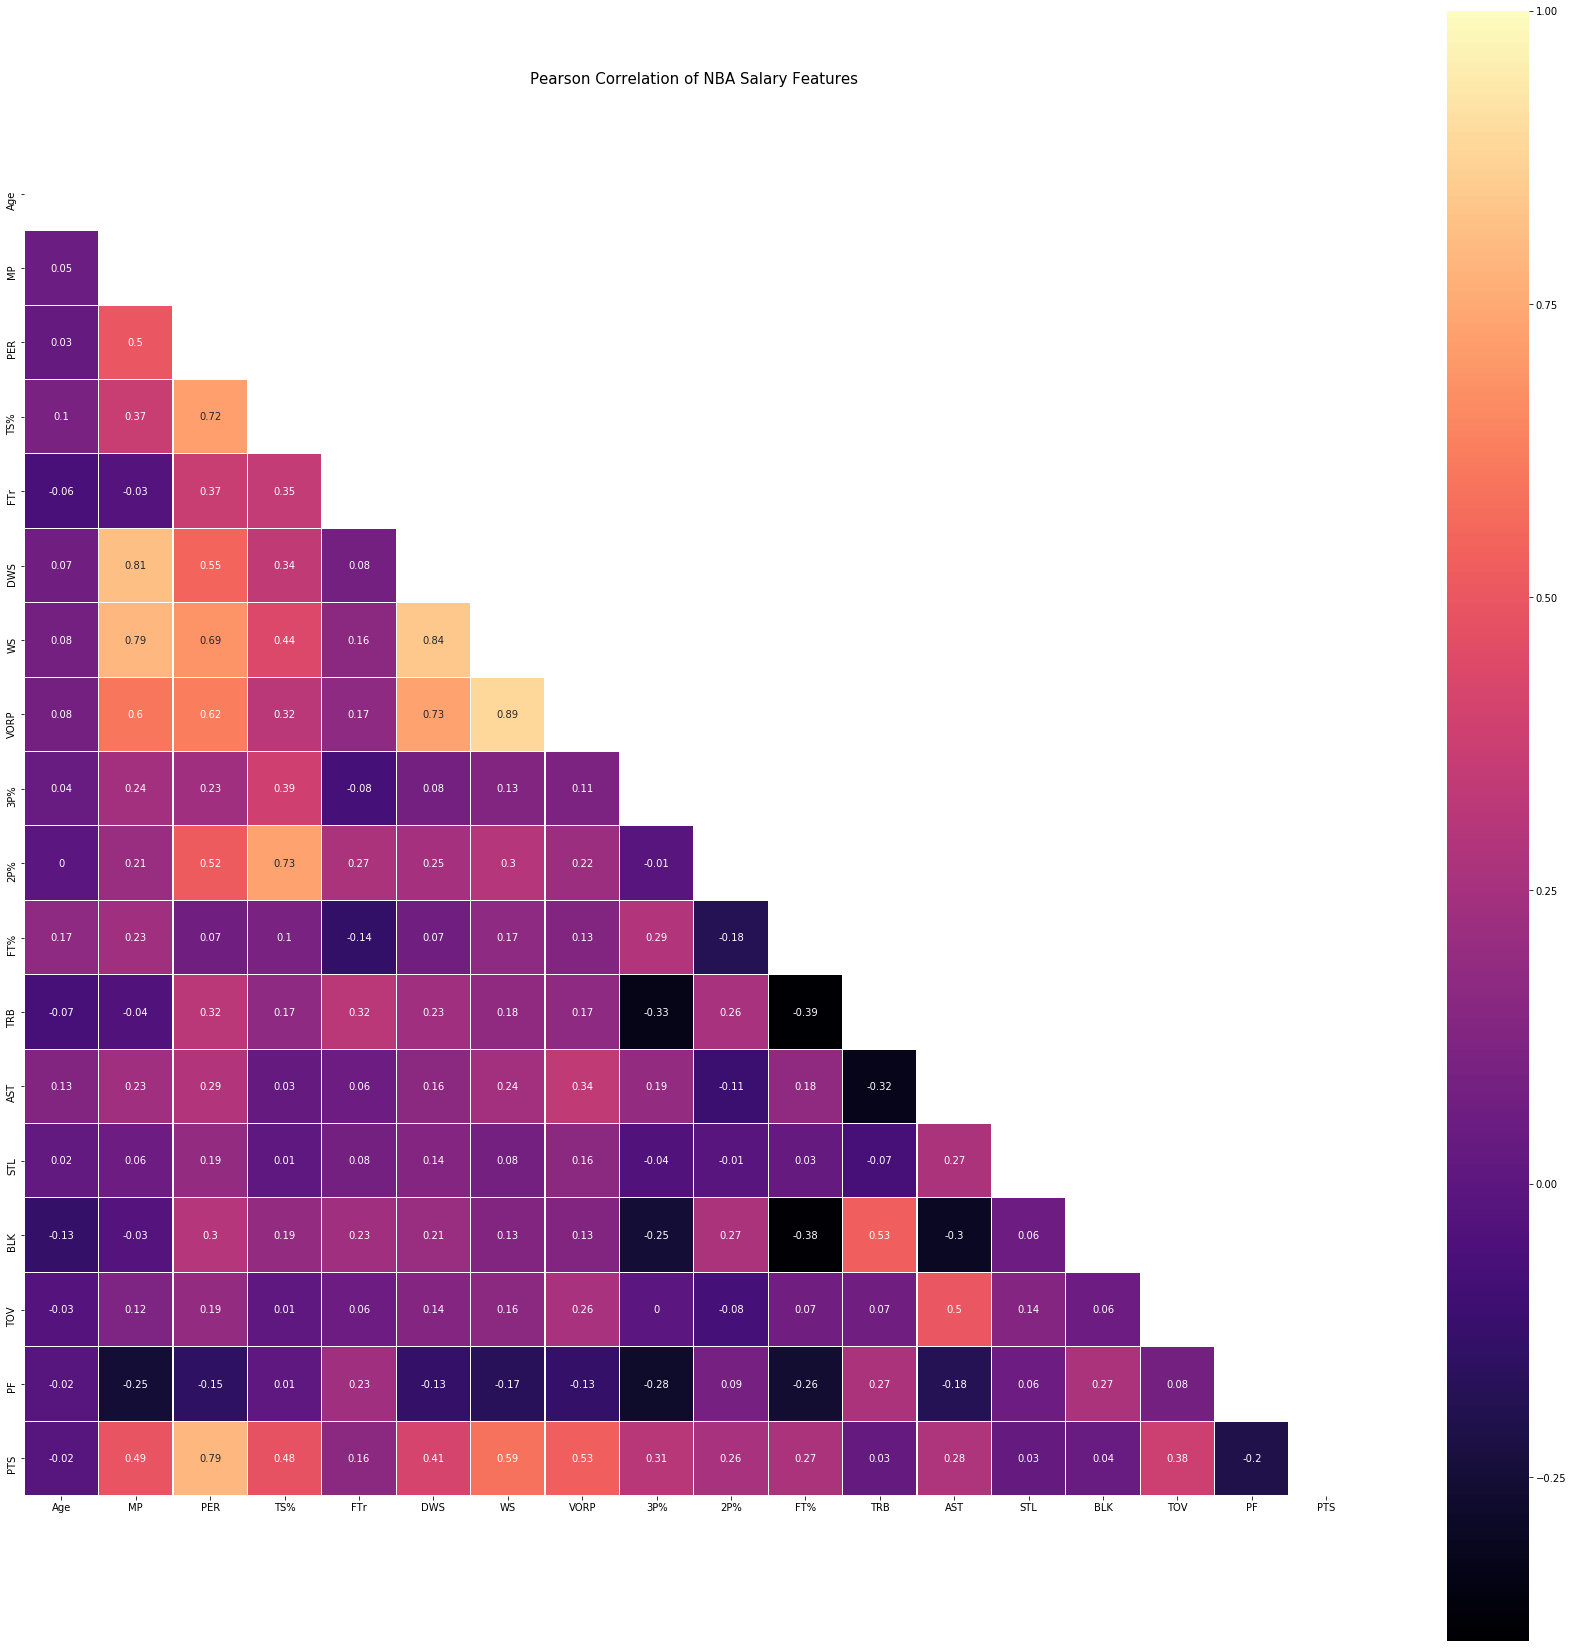

In [227]:
# Check correlation between features 

colormap = plt.cm.magma
plt.figure(figsize=(30,30))

plt.title('Pearson Correlation of NBA Salary Features', y=1.05, size=15)

corr = adv_per36.astype(float).corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool)

# mask upper diagonal of heatmap
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,\
            mask = mask, linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [228]:
# Use this cell for SpotRac salary data

# salaries_2017 = pd.read_csv('salary-data/average-salaries/2017.csv')

# set salaries index to match player name notation in statistics dataframe
# salaries_2017['Player'] = salaries_2017['first name'] + ' ' + salaries_2017['last name']
# salaries_2017.set_index('Player',drop=True,inplace=True)
# salaries_2017 = salaries_2017[['average salary']]
#salaries_2017.head()

In [229]:
# Use this cell for Bball Ref salary data (already removed rookie and non year-long contracts)

salaries_2017 = pd.read_csv('salary-data/average-salaries/2017-bballref.csv')
salaries_2017['Player'] = salaries_2017['Player'].apply(str)

index = 0

for i in salaries_2017['Player']:
    i = i.split("\\")[0]
    salaries_2017.iloc[index,1] = i
    index += 1

salaries_2017.set_index('Player',inplace=True)
salaries_2017 = salaries_2017[['Average Salary']]

# bin salaries by the million. label 0 = min, label 18 = >18M (i.e. max)
bins = [0,999999,1999999,2999999,3999999,4999999,5999999,6999999,7999999,8999999,9999999,10999999,11999999,12999999,13999999,14999999,15999999,16999999,17999999,salaries_2017.max()]
labels = []
for i in range(19):
    labels.append(i)

# bin salaries by the million. max cutoff at $18M, as this is generally the min of max contracts, where variance between maxes does is not indicative of skill level
salaries_2017 = pd.cut(salaries_2017['Average Salary'], bins = bins, labels = labels)
salaries_2017 = pd.DataFrame(salaries_2017)

In [230]:
# merge statistics and salary databases for players who have valid salaries from 2017

salary_statistics_2017 = adv_per36.merge(salaries_2017, how = 'inner', left_index = True, right_index = True)
salary_statistics_2017.head()

# 24 players NaN 3P%, 2 players NaN FT%. assume these players provide no value in these fields - fill with min from sample
print(salary_statistics_2017.isnull().sum())

salary_statistics_2017['3P%'].fillna(salary_statistics_2017['3P%'].min(), inplace = True)
salary_statistics_2017['FT%'].fillna(salary_statistics_2017['FT%'].min(), inplace = True)

Age                0
MP                 0
PER                0
TS%                0
FTr                0
DWS                0
WS                 0
VORP               0
3P%               24
2P%                0
FT%                2
TRB                0
AST                0
STL                0
BLK                0
TOV                0
PF                 0
PTS                0
Average Salary     0
dtype: int64


In [231]:
import math
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

standardize = StandardScaler()

statistics_no_salary = salary_statistics_2017.drop('Average Salary', axis = 1)
# split salary into training and test sets of features (stats) and predictions (salaries)
X_train, X_test, Y_train, Y_test = train_test_split(statistics_no_salary,\
                                                   salary_statistics_2017['Average Salary'],train_size = .8, test_size =.2,random_state=2)

In [232]:
# standardize data (min-max) - more accurate than normalizing
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)

# normalize data

# normalize = preprocessing.normalize
# X_train = normalize(X_train)
# X_test = normalize(X_test)

In [225]:
#KNN 

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)

knn_train_accuracy = knn.score(X_train, Y_train)
knn_test_accuracy = knn.score(X_test, Y_test)
print(knn_train_accuracy, knn_test_accuracy)
Y_pred = knn.predict(X_test)

Y_comparison = pd.DataFrame([Y_test])
Y_comparison = Y_comparison.T
Y_comparison['Predicted Salary'] = Y_pred
Y_comparison['Error'] = (Y_comparison['Average Salary'] - Y_comparison['Predicted Salary'])
Y_comparison

0.507518796992 0.432835820896


Average Salary  Predicted Salary  Error
Player                                                    
Ryan Anderson                  18                18      0
Mike Conley                    18                18      0
Alexis Ajinca                   5                 1      4
Jonathon Simmons                6                 1      5
DeAndre Jordan                 18                18      0
Jerryd Bayless                  8                 1      7
John Henson                    10                 1      9
DeMar DeRozan                  18                18      0
Joakim Noah                    18                 6     12
Elijah Millsap                  1                 1      0
Eric Bledsoe                   14                18     -4
Evan Fournier                  17                12      5
Kevin Love                     18                18      0
Jeremy Lin                     12                 2     10
Bojan Bogdanovic               10                 1      9
Salah Mejri                     1                 3     -2
Dennis Schroder                15                18     -3
Reggie Bullock                  2                 1      1
Ivica Zubac                     1                 1      0
Omri Casspi                     2                 1      1
Nemanja Bjelica                 3                 3      0
Meyers Leonard                 10                 1      9
Tyler Zeller                    1                 1      0
Paul George                    18                18      0
Joe Harris                      1                 1      0
Al-Farouq Aminu                 7                 3      4
Lou Williams                    7                18    -11
Wayne Ellington                 6                 8     -2
Dwyane Wade                    15                 2     13
Leandro Barbosa                 0                 0      0
...                           ...               ...    ...
Damjan Rudez                    1                 1      0
DeMarcus Cousins               18                18      0
Stephen Curry                  18                18      0
Ian Mahinmi                    16                 1     15
Zach Randolph                  12                 2     10
James Johnson                  14                18     -4
Kyle O'Quinn                    4                 1      3
Jrue Holiday                   18                18      0
Brook Lopez                    18                18      0
K.J. McDaniels                  1                 1      0
Monta Ellis                     2                 2      0
Anderson Varejao                1                 1      0
Kevin Durant                   18                18      0
Kemba Walker                   12                18     -6
Spencer Dinwiddie               1                 1      0
Langston Galloway               7                 3      4
Avery Bradley                   8                 3      5
Tony Snell                     11                12     -1
Tim Hardaway                   17                18     -1
Mike Muscala                    5                 1      4
Diamond Stone                   1                 1      0
Kawhi Leonard                  18                18      0
Deron Williams                  5                 3      2
Norman Powell                   1                 1      0
Ricky Rubio                    14                18     -4
Rudy Gobert                    18                18      0
Andre Iguodala                 16                 2     14
Vince Carter                    8                 2      6
Jamal Crawford                  4                 6     -2
Tobias Harris                  15                18     -3

[67 rows x 3 columns]

In [233]:
# SVM

svc = SVC(coef0 = 3)
svc.fit(X_train, Y_train)
svc_train_accuracy = svc.score(X_train, Y_train)
svc_test_accuracy = svc.score(X_test, Y_test)

print('SVC training accuracy:', svc_train_accuracy, '\nSVC Forest testing accuracy:', svc_test_accuracy)

SVC training accuracy: 0.398496240602 
SVC Forest testing accuracy: 0.402985074627


In [234]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=1200)
random_forest.fit(X_train, Y_train)
rf_train_accuracy = random_forest.score(X_train, Y_train)
rf_test_accuracy = random_forest.score(X_test, Y_test)

print('Random Forest training accuracy:', rf_train_accuracy, '\nRandom Forest testing accuracy:', rf_test_accuracy)

Random Forest training accuracy: 0.988721804511 
Random Forest testing accuracy: 0.373134328358
